In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [2]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)
print(gdf_gdl.shape)
gdf_gdl.head(2)

(8499, 4)


,Fuente,Tipo,Uso,geometry
0,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672507.028 2272132.201, 672520.126 2..."
1,"OpenStreetMap, [Online]. Disponible: http://ww...",Parque,Uso recreativo,"POLYGON ((672520.126 2272170.353, 672507.028 2..."


Filter data

In [3]:
gdf_gdl.Tipo.unique()

array(['Parque', 'Espacio verde vecinal', 'Glorieta', 'Camellón',
       'Área natural', 'Unidad deportiva', 'Plaza',
       'Área natural protegida'], dtype=object)

In [4]:
gdf_gdl = gdf_gdl.loc[(gdf_gdl.Tipo!='Glorieta')&(gdf_gdl.Tipo!='Camellón')].copy()
print(gdf_gdl.shape)

(4100, 4)


## Espacios Públicos QRO

In [5]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)
print(gdf_qro.shape)
gdf_qro.head(2)

(4814, 9)


,geografico,nombre,tipo,cveserv,cvegeo,geometria,fechaact,condicion,geometry
0,Bordo,Ninguno,No Aplica,036,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.14119 20.18851, -100.14112 20.1..."
1,Bordo,Ninguno,No Aplica,037,220010001,Area,12/2007,No Aplica,"POLYGON ((-100.13606 20.18186, -100.13603 20.1..."


In [6]:
gdf_qro.tipo.unique()

array(['No Aplica', 'Intermitente', 'CamellÃ\xa0n', 'Lienzo Charro',
       'Otro', 'Glorieta', 'Urbana', 'CamellÃ³n', 'Perenne',
       'Zona Industrial', 'Tanque Elevado', 'Granja o Establo',
       'Tiradero', 'Caja de Agua', 'Diverso', 'Monumento u Obelisco',
       'Planta de Tratamiento de Agua'], dtype=object)

Eliminar Querétaro

## Espacios Públicos CDMX

In [7]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)
print(gdf_cdmx.shape)
gdf_cdmx.head(2)

(11609, 13)


,id,geo_point_2d,geo_shape,subcat_sed,subcve_sed,gid,cve_delg,delegacion,categoria,superficie,perimetro,cve_sedema,geometry
0,0,"19.4877568178,-99.2060645931","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Panteones,604,268,2,Azcapotzalco,Equipamientos urbanos con vegetación,6660.027554,329.264738,600,"POLYGON ((-99.20639 19.48819, -99.20556 19.487..."
1,1,"19.3887689803,-99.116393168","{'type': 'MultiPolygon', 'coordinates': [[[[-9...",Deportivos,601,87,8,Iztacalco,Equipamientos urbanos con vegetación,2917.257837,272.2436142,600,"POLYGON ((-99.11679 19.38904, -99.11637 19.388..."


In [8]:
gdf_cdmx.categoria.unique()

array(['Equipamientos urbanos con vegetación',
       'Áreas verdes complementarias o ligadas a la red vial',
       'Plazas y jardines', 'Parques, arboledas y alamedas',
       'Áreas verdes urbanas fragmentadas',
       'Áreas verdes con estructura urbana',
       'Áreas con categoría de protección',
       'Áreas con vegetación reminisciente',
       'Áreas con características de protección'], dtype=object)

In [9]:
gdf_cdmx.subcat_sed.unique()

array(['Panteones', 'Deportivos', 'Camellones centrales y laterales',
       'Unidades habitacionales', 'Instituciones académicas públicas',
       'Plazas', 'Asistencia Social con vegetación CDMX', 'Parques',
       'Veg. Arbórea, arbustiva y herbácea de glorietas', 'Vialidades',
       'Instituciones académicas privadas', 'Arboledas',
       'Instituciones de salud pub/priv', 'Jardines públicos', 'Canales',
       'Jardineras públicas y privadas', 'Azoteas verdes', 'Bordos',
       'Terrenos baldíos', 'AVA', 'Depresiones orográficas', 'ANP',
       'Alamedas', 'Promontorios', 'Colinas', 'Cerros',
       'Zona de recarga de manto acuíferos'], dtype=object)

Filter data

In [9]:
gdf_cdmx = gdf_cdmx[gdf_cdmx['subcat_sed'].isin(['Deportivos','Plazas','Parques',
                                     'Arboledas','Jardines públicos','Jardineras públicas y privadas',
                                     'ANP','Alamedas'])]
print(gdf_cdmx.shape)

(2427, 13)


## Juntamos en un dataset

In [10]:
gdf_gdl = gdf_gdl.to_crs("EPSG:4326")
# gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.to_crs("EPSG:4326")
print("CRS of gdf_gdl:", gdf_gdl.crs)
# print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_cdmx: epsg:4326


In [11]:
geodataframes = [gdf_gdl, gdf_cdmx]
ep_gdf = pd.concat(geodataframes)
ep_gdf = ep_gdf[['geometry']]
ep_gdf.head()

,geometry
0,"POLYGON ((-103.34533 20.54017, -103.34520 20.5..."
1,"POLYGON ((-103.34520 20.54051, -103.34533 20.5..."
2,"POLYGON ((-103.34546 20.53983, -103.34559 20.5..."
3,"POLYGON ((-103.34559 20.53952, -103.34546 20.5..."
4,"POLYGON ((-103.34571 20.53916, -103.34583 20.5..."


In [12]:
ep_gdf.shape

(6527, 1)

### Delete GeoDataFrames

In [13]:
del gdf_gdl
del gdf_cdmx
del geodataframes

## Hexágonos 3 ciudades

In [14]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
# hex_table_tempt = "temperature_analysis_hex"
# hex_schema_pob = "hexgrid"
# hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
print(hex_gdf.shape)
hex_gdf.head(5)

(906258, 3)


,hex_id,geometry,city
0,8b499584a09afff,"POLYGON ((-99.17332 19.35547, -99.17314 19.355...",CDMX
1,8b499584a082fff,"POLYGON ((-99.17391 19.35431, -99.17374 19.354...",CDMX
2,8b499584a081fff,"POLYGON ((-99.17479 19.35440, -99.17461 19.354...",CDMX
3,8b499584a091fff,"POLYGON ((-99.17345 19.35451, -99.17327 19.354...",CDMX
4,8b499584a083fff,"POLYGON ((-99.17432 19.35460, -99.17414 19.354...",CDMX


In [16]:
'''hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
hex_table_tempt = "temperature_analysis_hex"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Querétaro'
n = '11'
query = f"""
SELECT h1.hex_id, h1.geometry, h1.city 
FROM {hex_schema}.{hex_table} h1
JOIN {hex_schema}.{hex_table_tempt} h2
ON h1.hex_id = h2.hex_id
WHERE h1.city IN ('{c1}', '{c2}') AND h1.res = {n}
"""
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdf.head(5)'''

'hex_schema = "raster_analysis"\nhex_table = "ndvi_analysis_hex"\nhex_table_tempt = "temperature_analysis_hex"\nhex_schema_pob = "hexgrid"\nhex_table_pob = "hexgrid_9_city_2020"\nc1 = \'Guadalajara\'\nc2 =\'CDMX\'\n#c3 = \'Querétaro\'\nn = \'11\'\nquery = f"""\nSELECT h1.hex_id, h1.geometry, h1.city \nFROM {hex_schema}.{hex_table} h1\nJOIN {hex_schema}.{hex_table_tempt} h2\nON h1.hex_id = h2.hex_id\nWHERE h1.city IN (\'{c1}\', \'{c2}\') AND h1.res = {n}\n"""\nhex_gdf = aup.gdf_from_query(query, geometry_col=\'geometry\')\n#query = \'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11\'\nhex_gdf.head(5)'

In [15]:
hex_gdf['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [16]:
contador_gdl = np.sum(hex_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdf['city'] == 'CDMX')
#contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 493251 
Número de hexágonos Cdmx: 413007


In [17]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")
print("CRS of hex_gdf:", hex_gdf.crs)

CRS of hex_gdf: epsg:4326


In [20]:
# contador_gdl = np.sum(hex_gdl['city'] == 'Guadalajara')
# contador_cdmx = np.sum(hex_gdl['city'] == 'CDMX')
# contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
# print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

### Plot data

<Axes: >

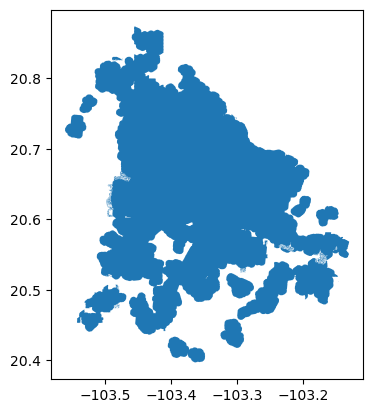

In [18]:
hex_gdf.loc[hex_gdf.city=='Guadalajara'].dissolve().plot()

<Axes: >

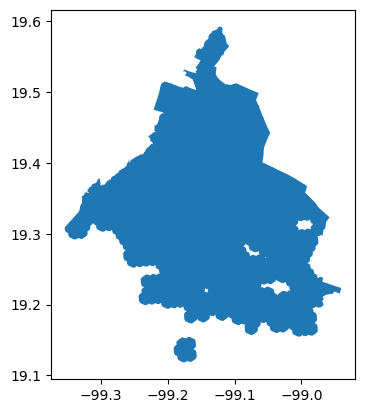

In [19]:
hex_gdf.loc[hex_gdf.city=='CDMX'].dissolve().plot()

## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [20]:
gdf_sindex = ep_gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdf['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdf['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdf.head()

,hex_id,geometry,city,EspPublico
0,8b499584a09afff,"POLYGON ((-99.17332 19.35547, -99.17314 19.355...",CDMX,0
1,8b499584a082fff,"POLYGON ((-99.17391 19.35431, -99.17374 19.354...",CDMX,0
2,8b499584a081fff,"POLYGON ((-99.17479 19.35440, -99.17461 19.354...",CDMX,0
3,8b499584a091fff,"POLYGON ((-99.17345 19.35451, -99.17327 19.354...",CDMX,0
4,8b499584a083fff,"POLYGON ((-99.17432 19.35460, -99.17414 19.354...",CDMX,0


In [21]:
contador_ceros = np.sum(hex_gdf['EspPublico'] == 0)
contador_uno = np.sum(hex_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 779728 
Número de Hexágonos con Espacios Públicos: 126530
Número total de Hexágonos: 906258


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [22]:
hex_schema = "raster_analysis"
hex_schema_pob = "hexgrid"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_tempt = "temperature_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
temp = "temp"
poblation = "POBTOT"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='CDMX'
#c3 = 'Queretaro'
n = '11'

query = f'''
SELECT 
    temp.hex_id, 
    temp.city, 
    temp.geometry AS geometry,  
    temp.res AS temp_res,
    ndmi.geometry AS ndmi_geometry, 
    ndmi.city AS ndmi_city, 
    ndmi.res AS ndmi_res, 
    ndvi.geometry AS ndvi_geometry, 
    ndvi.city AS ndvi_city, 
    ndvi.res AS ndvi_res, 
    ndvi.ndvi_mean, 
    ndvi.ndvi_std, 
    ndvi.ndvi_median, 
    ndvi.ndvi_max, 
    ndvi.ndvi_min, 
    ndvi.ndvi_diff, 
    ndvi.ndvi_tend,
    ndmi.ndmi_mean, 
    ndmi.ndmi_median, 
    ndmi.ndmi_diff, 
    temp.temp_diff_mean
FROM 
    {hex_schema}.{hex_table_tempt} temp  
INNER JOIN 
    {hex_schema}.{hex_table} ndmi 
    ON temp.hex_id = ndmi.hex_id
INNER JOIN 
    {hex_schema}.{hex_tablee} ndvi 
    ON ndmi.hex_id = ndvi.hex_id
WHERE 
    temp.city IN ('{c1}', '{c2}') 
    AND temp.res = {n}
'''

variables_gdf = aup.gdf_from_query(query, geometry_col='geometry')
variables_gdf.head(10)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean
0,8b4995b81ac2fff,CDMX,"POLYGON ((-99.17077 19.47319, -99.17059 19.473...",11,0103000020E61000000100000007000000F28C72D0EDCA...,CDMX,11,0103000020E61000000100000007000000F28C72D0EDCA...,CDMX,11,...,0.062977,0.301923,0.305287,0.248413,0.056874,-0.002475,0.044777,0.047126,0.054843,-1.779053
1,8b499584a09efff,CDMX,"POLYGON ((-99.17338 19.35499, -99.17321 19.355...",11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,...,0.165089,0.637277,0.648746,0.489500,0.159245,-0.005960,0.133597,0.133750,0.035030,-6.167781
2,8b499584a383fff,CDMX,"POLYGON ((-99.18000 19.35860, -99.17982 19.358...",11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,...,0.093463,0.393257,0.402223,0.294147,0.108076,-0.003056,0.047486,0.047518,0.023174,-0.999885
3,8b499584a770fff,CDMX,"POLYGON ((-99.17603 19.35843, -99.17586 19.358...",11,0103000020E61000000100000007000000C157052544CB...,CDMX,11,0103000020E61000000100000007000000C157052544CB...,CDMX,11,...,0.059681,0.261335,0.277177,0.199614,0.077563,-0.001883,-0.024156,-0.021614,0.034185,1.158667
4,8b499584a040fff,CDMX,"POLYGON ((-99.18050 19.35476, -99.18033 19.354...",11,0103000020E610000001000000070000003E315E5A8DCB...,CDMX,11,0103000020E610000001000000070000003E315E5A8DCB...,CDMX,11,...,0.073330,0.327973,0.348942,0.256151,0.092791,-0.002721,0.044212,0.041209,0.028514,-1.570342
5,8b499584e521fff,CDMX,"POLYGON ((-99.17278 19.32573, -99.17260 19.325...",11,0103000020E6100000010000000700000089CC52CF0ECB...,CDMX,11,0103000020E6100000010000000700000089CC52CF0ECB...,CDMX,11,...,0.026481,0.085590,0.103649,0.074508,0.029141,-0.001131,-0.042399,-0.045157,0.052605,-0.195719
6,8b4995b15c19fff,CDMX,"POLYGON ((-99.25487 19.37936, -99.25469 19.379...",11,0103000020E61000000100000007000000A3A259CA4FD0...,CDMX,11,0103000020E61000000100000007000000A3A259CA4FD0...,CDMX,11,...,0.083323,0.248537,0.273542,0.183292,0.090250,-0.003239,-0.010718,-0.009262,0.053656,-0.389136
7,8b4995b10399fff,CDMX,"POLYGON ((-99.23956 19.40159, -99.23938 19.401...",11,0103000020E610000001000000070000004DA801E054CF...,CDMX,11,0103000020E610000001000000070000004DA801E054CF...,CDMX,11,...,0.085871,0.356583,0.394312,0.277469,0.116843,-0.002862,0.019353,0.018797,0.036956,-1.849422
8,8b4995b1070dfff,CDMX,"POLYGON ((-99.23484 19.40037, -99.23466 19.400...",11,0103000020E6100000010000000700000026CD109207CF...,CDMX,11,0103000020E6100000010000000700000026CD109207CF...,CDMX,11,...,0.031201,0.148279,0.193458,0.136051,0.057407,-0.000247,-0.017790,-0.014794,0.037606,-0.784938
9,8b4995b14691fff,CDMX,"POLYGON ((-99.23203 19.38110, -99.23185 19.381...",11,0103000020E61000000100000007000000F6B1CB93D9CE...,CDMX,11,0103000020E61000000100000007000000F6B1CB93D9CE...,CDMX,11,...,0.013163,0.056116,0.065467,0.041723,0.023744,-0.000451,-0.056418,-0.057443,0.028646,1.768851


In [23]:
variables_gdf.shape

(807653, 21)

In [24]:
variables_gdf['city'].unique()

array(['CDMX', 'Guadalajara'], dtype=object)

In [25]:
contador_gdl = np.sum(variables_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(variables_gdf['city'] == 'CDMX')
#intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 445881 
Número de hexágonos Cdmx: 361772


## Intersección

In [29]:
# intt_gdl = intt_gdl.set_crs("EPSG:4326")
# hex_gdl = hex_gdl.set_crs("EPSG:4326")

In [26]:
variables_gdf = variables_gdf.merge(hex_gdf[['hex_id','EspPublico']], on='hex_id',
                      how='left')
print(variables_gdf.shape)
variables_gdf.head()

(968415, 22)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico
0,8b4995b81ac2fff,CDMX,"POLYGON ((-99.17077 19.47319, -99.17059 19.473...",11,0103000020E61000000100000007000000F28C72D0EDCA...,CDMX,11,0103000020E61000000100000007000000F28C72D0EDCA...,CDMX,11,...,0.301923,0.305287,0.248413,0.056874,-0.002475,0.044777,0.047126,0.054843,-1.779053,0
1,8b499584a09efff,CDMX,"POLYGON ((-99.17338 19.35499, -99.17321 19.355...",11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,0103000020E61000000100000007000000F4E2C2B118CB...,CDMX,11,...,0.637277,0.648746,0.489500,0.159245,-0.005960,0.133597,0.133750,0.035030,-6.167781,0
2,8b499584a383fff,CDMX,"POLYGON ((-99.18000 19.35860, -99.17982 19.358...",11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,0103000020E61000000100000007000000F7DFD21F85CB...,CDMX,11,...,0.393257,0.402223,0.294147,0.108076,-0.003056,0.047486,0.047518,0.023174,-0.999885,0
3,8b499584a770fff,CDMX,"POLYGON ((-99.17603 19.35843, -99.17586 19.358...",11,0103000020E61000000100000007000000C157052544CB...,CDMX,11,0103000020E61000000100000007000000C157052544CB...,CDMX,11,...,0.261335,0.277177,0.199614,0.077563,-0.001883,-0.024156,-0.021614,0.034185,1.158667,0
4,8b499584a040fff,CDMX,"POLYGON ((-99.18050 19.35476, -99.18033 19.354...",11,0103000020E610000001000000070000003E315E5A8DCB...,CDMX,11,0103000020E610000001000000070000003E315E5A8DCB...,CDMX,11,...,0.327973,0.348942,0.256151,0.092791,-0.002721,0.044212,0.041209,0.028514,-1.570342,0


In [31]:
# inter.drop(columns=['index_right','city_right','hex_id_right'], inplace=True)
# inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)

Remove rows with NaN

In [27]:
# inter['temp_diff_mean'] = inter['temp_diff_mean'].fillna(0)
variables_gdf = variables_gdf.dropna()
print(variables_gdf.shape)

(968405, 22)


Count data

In [28]:
contador_gdl = np.sum(variables_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(variables_gdf['city'] == 'CDMX')
#contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

Número de hexágonos Gdl: 606633 
Número de hexágonos Cdmx: 361772


In [29]:
cont_no_ep = np.sum(variables_gdf['EspPublico'] == 0)
cont_ep = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_no_ep} \nNúmero de Hexágonos con Espacios Públicos: {cont_ep}\nNúmero total de Hexágonos: {cont_no_ep+cont_ep}')

Números de hexagonos sin Espacios Públicos: 814728 
Número de Hexágonos con Espacios Públicos: 153677
Número total de Hexágonos: 968405


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [30]:
num_samples = len(variables_gdf[variables_gdf['EspPublico'] == 1]) # selecciona variables de acuerdo con el total de hexagonos con ep

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = variables_gdf[variables_gdf['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = variables_gdf[variables_gdf['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
variables_gdf = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
variables_gdf.reset_index(drop = True, inplace = True)
print(variables_gdf.shape)
variables_gdf.head()

(307354, 22)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico
0,8b4995b8e69dfff,CDMX,"POLYGON ((-99.15161 19.50427, -99.15143 19.504...",11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,...,0.316529,0.339638,0.251868,0.087769,-0.002195,0.057328,0.059302,0.057467,3.501037,1
1,8b4995b81101fff,CDMX,"POLYGON ((-99.16311 19.46728, -99.16293 19.467...",11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,...,0.075551,0.094672,0.059489,0.035183,-0.000604,0.005624,0.004089,0.028450,1.798855,1
2,8b498c96bb08fff,Guadalajara,"POLYGON ((-103.38599 20.70204, -103.38581 20.7...",11,0103000020E61000000100000007000000DFE14001B4D8...,Guadalajara,11,0103000020E61000000100000007000000DFE14001B4D8...,Guadalajara,11,...,0.169769,0.199559,0.145375,0.054183,-0.001158,-0.013968,-0.015438,0.037382,-1.232964,1
3,8b49ab58e430fff,Guadalajara,"POLYGON ((-103.48096 20.65465, -103.48078 20.6...",11,0103000020E61000000100000007000000B9000FFEC7DE...,Guadalajara,11,0103000020E61000000100000007000000B9000FFEC7DE...,Guadalajara,11,...,0.601559,0.692499,0.324420,0.368078,-0.004906,0.082445,0.098110,0.221515,-8.256748,1
4,8b498c9246c0fff,Guadalajara,"POLYGON ((-103.19056 20.52179, -103.19039 20.5...",11,0103000020E61000000100000007000000EE53303332CC...,Guadalajara,11,0103000020E61000000100000007000000EE53303332CC...,Guadalajara,11,...,0.282776,0.694899,0.114505,0.580394,-0.002742,-0.025280,-0.113926,0.422594,-0.132518,1


In [36]:
cont_no_ep = np.sum(variables_gdf['EspPublico'] == 0)
contador_ep = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_no_ep} \nNúmero de Hexágonos con Espacios Públicos: {contador_ep}\nNúmero total de Hexágonos: {cont_no_ep+contador_ep}')

Números de hexagonos sin Espacios Públicos: 153677 
Número de Hexágonos con Espacios Públicos: 153677
Número total de Hexágonos: 307354


### Del data

In [31]:
del sample_with_public_spaces
del sample_without_public_spaces

## Download population data

Download urban hexagons by city

In [32]:
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
c1 = 'Guadalajara'
c2 = 'CDMX'
n = "9"
t = "urban"

#Consulta para la tabla de población (solo tipo urbano y ciudades seleccionadas):
query_pob = f"""
SELECT * 
FROM {hex_schema_pob}.{hex_table_pob} 
WHERE city IN ('{c1}', '{c2}') 
AND type = '{t}'
"""

hex_urban = aup.gdf_from_query(query_pob, geometry_col='geometry')
print(hex_urban.shape)
hex_urban.head(5)

(13629, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban
2,89498c97333ffff,"POLYGON ((-103.27379 20.66284, -103.27257 20.6...",14039,Guadalajara,Guadalajara,urban
3,89498c96063ffff,"POLYGON ((-103.33352 20.63689, -103.33230 20.6...",14039,Guadalajara,Guadalajara,urban
4,89498c95cb3ffff,"POLYGON ((-103.29386 20.71601, -103.29264 20.7...",14039,Guadalajara,Guadalajara,urban


Download hexagons with population data by city

In [33]:
#Consulta para la tabla de manzanas (solo ciudades seleccionadas):
hex_schema_mza = "censo"
hex_table_mza = "hex_censo_mza_2020_res9"

query_mza = f"""
SELECT hex_id_9, pobtot, geometry
FROM {hex_schema_mza}.{hex_table_mza} WHERE
hex_id_9 IN {str(tuple(hex_urban.hex_id_9.unique()))}
"""
hex_pop = aup.gdf_from_query(query_mza, geometry_col='geometry')
print(hex_pop.shape)
hex_pop.head(2)

(11815, 3)


,hex_id_9,pobtot,geometry
0,89499584547ffff,1265.0,"POLYGON ((-99.17964 19.28341, -99.17841 19.284..."
1,8949958cc9bffff,1717.0,"POLYGON ((-99.04364 19.37460, -99.04240 19.376..."


In [40]:
# pob = hex_gdl_pob.shape
# mza = hex_gdl_mza.shape

# print(pob)
# print(mza)

In [41]:
# hex_pop['city'].unique()

In [42]:
'''hex_schema_mza = "censo"
hex_schema_pob = "hexgrid"
hex_table_pob = "hexgrid_9_city_2020"
hex_table_mza = "hex_censo_mza_2020_res9"
c1 = 'Guadalajara'
c2 = 'CDMX'
t = "urban"


query_join = f"""
SELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry
FROM {hex_schema_pob}.{hex_table_pob} pob
INNER JOIN {hex_schema_mza}.{hex_table_mza} mza
ON pob.hex_id_9 = mza.hex_id_9
WHERE pob.city IN ('{c1}', '{c2}') 
AND pob.type = '{t}'
"""

hex_gdl_join = aup.gdf_from_query(query_join, geometry_col='geometry')

hex_gdl_join.head(5)'''


'hex_schema_mza = "censo"\nhex_schema_pob = "hexgrid"\nhex_table_pob = "hexgrid_9_city_2020"\nhex_table_mza = "hex_censo_mza_2020_res9"\nc1 = \'Guadalajara\'\nc2 = \'CDMX\'\nt = "urban"\n\n\nquery_join = f"""\nSELECT pob.hex_id_9, pob.city, pob.type, mza.pobtot, mza.geometry\nFROM {hex_schema_pob}.{hex_table_pob} pob\nINNER JOIN {hex_schema_mza}.{hex_table_mza} mza\nON pob.hex_id_9 = mza.hex_id_9\nWHERE pob.city IN (\'{c1}\', \'{c2}\') \nAND pob.type = \'{t}\'\n"""\n\nhex_gdl_join = aup.gdf_from_query(query_join, geometry_col=\'geometry\')\n\nhex_gdl_join.head(5)'

In [43]:
# contador_gdl_join = np.sum(hex_gdl_join['city'] == 'Guadalajara')
# contador_cdmxx_join = np.sum(hex_gdl_join['city'] == 'CDMX')
# print(f'Número de hexágonos Gdl: {contador_gdl_join} \nNúmero de hexágonos Cdmx: {contador_cdmxx_join}')

In [44]:
# hex_gdl_join = hex_gdl_join.set_crs("EPSG:4326", allow_override=True)
# print("CRS of gdf_gdl:", gdf_gdl.crs)

## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [45]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
# intersects_public_spaces = hex_gdl_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# hex_gdl_join['EspPublico'] = intersects_public_spaces.astype(int)
# hex_gdl_join.head()

In [46]:
# contador_ceros_join = np.sum(hex_gdl_join['EspPublico'] == 0)
# contador_uno_join = np.sum(hex_gdl_join['EspPublico'])
# print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

## Intersección espacial

In [47]:
# pd.isna(hex_gdl_join).sum()

In [48]:
# hex_gdl_pob = hex_gdl_pob.set_crs("EPSG:4326")
# hex_gdl_mza = hex_gdl_mza.set_crs("EPSG:4326")

In [49]:
# inter_join = gpd.sjoin(hex_gdl_pob, hex_gdl_mza, op='intersects')
# print(inter_join)

In [50]:
# inter_join.drop(columns=['index_right', 'hex_id_9_right'], inplace=True)
# inter_join.rename(columns={"hex_id_9_left": "hex_id_9"}, inplace=True)
# inter_join.head()

In [51]:
# pd.isna(inter_join).sum()

Extract centroids for spatial intersection

In [34]:
hex_cnt = hex_gdf.copy()
hex_cnt['geometry'] = hex_cnt.to_crs("EPSG:6372").centroid # set to meter projection and extract centroid
hex_cnt = hex_cnt.to_crs("EPSG:4326")
print(hex_cnt.shape)
hex_cnt.head(2)

(906258, 4)


,hex_id,geometry,city,EspPublico
0,8b499584a09afff,POINT (-99.17343 19.35572),CDMX,0
1,8b499584a082fff,POINT (-99.17403 19.35457),CDMX,0


Plot data

<Axes: >

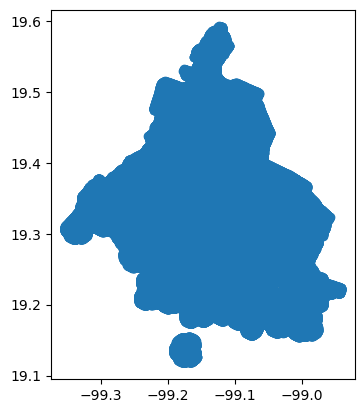

In [35]:
hex_cnt.loc[hex_cnt.city=='CDMX'].plot()

Spatial intersection between hexagons centroids with res 11 and hexagons with res 9

In [36]:
hex_cnt = hex_cnt.sjoin(hex_pop[['pobtot','geometry']])
print(hex_cnt.shape)
hex_cnt.head(2)

(644334, 6)


,hex_id,geometry,city,EspPublico,index_right,pobtot
0,8b499584a09afff,POINT (-99.17343 19.35572),CDMX,0,2204,233.0
1,8b499584a082fff,POINT (-99.17403 19.35457),CDMX,0,2204,233.0


Pass population data to variables_gdf

In [37]:
variables_gdf = variables_gdf.merge(hex_cnt[['hex_id','pobtot']], on='hex_id', how='inner')
print(variables_gdf.shape)
variables_gdf.head(2)

(343225, 23)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot
0,8b4995b8e69dfff,CDMX,"POLYGON ((-99.15161 19.50427, -99.15143 19.504...",11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,...,0.339638,0.251868,0.087769,-0.002195,0.057328,0.059302,0.057467,3.501037,1,398.0
1,8b4995b81101fff,CDMX,"POLYGON ((-99.16311 19.46728, -99.16293 19.467...",11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,...,0.094672,0.059489,0.035183,-0.000604,0.005624,0.004089,0.028450,1.798855,1,2136.0


In [56]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
#  intersects_public_spaces = inter_join['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# inter_join['EspPublico'] = intersects_public_spaces.astype(int)
# inter_join.head()

In [38]:
cont_ceros = np.sum(variables_gdf['EspPublico'] == 0)
cont_uno = np.sum(variables_gdf['EspPublico'] == 1)
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros + cont_uno}')

Números de hexagonos sin Espacios Públicos: 161667 
Número de Hexágonos con Espacios Públicos: 181558
Número total de Hexágonos: 343225


## [SKIP] Submuestreo población

In [58]:
num_samples_join = len(inter_join[inter_join['EspPublico'] == 1])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = inter_join[inter_join['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = inter_join[inter_join['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
inter_join = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
inter_join.reset_index(drop = True, inplace = True)
inter_join.head()

NameError: name 'inter_join' is not defined

In [ ]:
contador_ceros_join = np.sum(inter_join['EspPublico'] == 0)
contador_uno_join = np.sum(inter_join['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

In [ ]:
inter_join.shape

## [SKIP] Intersección espacial con población, vegetación, humedad y temperatura.

In [ ]:
gdl_samples_inter = 222941
cdmx_samples_inter = 180886


# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = inter[inter['city'] == 'Guadalajara'].sample(n=gdl_samples_inter, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = inter[inter['city'] == 'CDMX'].sample(n=cdmx_samples_inter, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_Guadalajara, sample_with_Cdmx])
inter.reset_index(drop = True, inplace = True)
inter.head()

In [ ]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'CDMX')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx}')

In [ ]:
inter = inter.set_crs("EPSG:4326")
inter_join = inter_join.set_crs("EPSG:4326")

In [ ]:
# Simplificar las geometrías
inter['geometry'] = inter['geometry'].simplify(tolerance=0.01)
inter_join['geometry'] = inter_join['geometry'].simplify(tolerance=0.01)

# Realizar la intersección con geometrías simplificadas
simplified_intersection = gpd.overlay(inter, inter_join, how='intersection')


In [ ]:
simplified_intersection.head()

In [ ]:
simplified_intersection.drop(columns=["city_1", "EspPublico_1"], inplace=True)
simplified_intersection.rename(columns={"city_2": "city", "EspPublico_2": "EspPublico"}, inplace=True)
simplified_intersection.head()

## PCA

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = ['pobtot', 'ndvi_mean', 'ndvi_std', 'ndvi_median', 'ndvi_max', 'ndvi_min', 'ndvi_diff', 
            'ndvi_tend', 'ndmi_mean', 'ndmi_median', 'ndmi_diff', 'temp_diff_mean']

df_features = variables_gdf[features]
df_features.replace([np.inf, -np.inf], np.nan, inplace=True)
df_features.fillna(df_features.mean(), inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

pca = PCA(n_components= 5)  #Cambia n_components si necesitas más o menos dimensiones
pca_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2', "PCA3", "PCA4","PCA5"])

# simplified_intersection = simplified_intersection.reset_index(drop=True)
variables_gdf['PCA1'] = pca_df['PCA1']
variables_gdf['PCA2'] = pca_df['PCA2']
variables_gdf["PCA3"] = pca_df["PCA3"]
variables_gdf["PCA4"] = pca_df["PCA4"]
variables_gdf["PCA5"] = pca_df["PCA5"]




In [40]:
# Aplicar PCA con todos los componentes
pca = PCA(n_components=len(features))
pca.fit(scaled_features)

# Varianza explicada por cada componente
explained_variance_ratio = pca.explained_variance_ratio_

# Varianza acumulada
cumulative_variance = np.cumsum(explained_variance_ratio)

In [41]:
#Varianza explicada por cada componente:
explained_variance_ratio = pca.explained_variance_ratio_

#Varianza acumulada:
cumulative_variance = np.cumsum(explained_variance_ratio)

for i, var in enumerate(cumulative_variance):
    print(f"Componente {i+1}: Varianza acumulada = {var:.4f}")

Componente 1: Varianza acumulada = 0.6333
Componente 2: Varianza acumulada = 0.8064
Componente 3: Varianza acumulada = 0.8726
Componente 4: Varianza acumulada = 0.9231
Componente 5: Varianza acumulada = 0.9722
Componente 6: Varianza acumulada = 0.9896
Componente 7: Varianza acumulada = 0.9966
Componente 8: Varianza acumulada = 0.9982
Componente 9: Varianza acumulada = 0.9993
Componente 10: Varianza acumulada = 0.9999
Componente 11: Varianza acumulada = 1.0000
Componente 12: Varianza acumulada = 1.0000


In [42]:
# gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
# intersects_public_spaces = variables_gdf['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

# simplified_intersection['EspPublico'] = intersects_public_spaces.astype(int)
# simplified_intersection.head()
print(variables_gdf.shape)
variables_gdf.head(4)

(343225, 28)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
0,8b4995b8e69dfff,CDMX,"POLYGON ((-99.15161 19.50427, -99.15143 19.504...",11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,0103000020E610000001000000070000003D203CF7B3C9...,CDMX,11,...,0.059302,0.057467,3.501037,1,398.0,1.212195,1.509943,-0.319426,-1.672866,1.608301
1,8b4995b81101fff,CDMX,"POLYGON ((-99.16311 19.46728, -99.16293 19.467...",11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,0103000020E610000001000000070000001414AB6D70CA...,CDMX,11,...,0.004089,0.028450,1.798855,1,2136.0,-2.704791,0.965218,0.577013,0.479284,0.919649
2,8b498c96bb08fff,Guadalajara,"POLYGON ((-103.38599 20.70204, -103.38581 20.7...",11,0103000020E61000000100000007000000DFE14001B4D8...,Guadalajara,11,0103000020E61000000100000007000000DFE14001B4D8...,Guadalajara,11,...,-0.015438,0.037382,-1.232964,1,839.0,-1.102844,0.760424,-0.686403,0.347639,-0.417775
3,8b498c9246c0fff,Guadalajara,"POLYGON ((-103.19056 20.52179, -103.19039 20.5...",11,0103000020E61000000100000007000000EE53303332CC...,Guadalajara,11,0103000020E61000000100000007000000EE53303332CC...,Guadalajara,11,...,-0.113926,0.422594,-0.132518,1,328.0,3.595611,-5.238854,0.691620,0.304129,-0.002733


In [43]:
cont_ceros_join = np.sum(variables_gdf['EspPublico'] == 0)
cont_uno_join = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno_join}\nNúmero total de Hexágonos: {cont_ceros_join + cont_uno_join}')

Números de hexagonos sin Espacios Públicos: 161667 
Número de Hexágonos con Espacios Públicos: 181558
Número total de Hexágonos: 343225


### Submuestreo de todas las variables

In [44]:
num_samples_join = len(variables_gdf[variables_gdf['EspPublico'] == 0])

# Randomly sample 80632 hexagons with public spaces
sample_with_public_spaces_join = variables_gdf[variables_gdf['EspPublico'] == 1].sample(n=num_samples_join, random_state=42)

# Randomly sample 80632 hexagons without public spaces
sample_without_public_spaces_join = variables_gdf[variables_gdf['EspPublico'] == 0].sample(n=num_samples_join, random_state=42)

# Concatenate the two samples to get the final subsample
variables_gdf = pd.concat([sample_with_public_spaces_join, sample_without_public_spaces_join])
variables_gdf.reset_index(drop = True, inplace = True)
print(variables_gdf.shape)
variables_gdf.head(4)

(323334, 28)


,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
0,8b49ab583548fff,Guadalajara,"POLYGON ((-103.46501 20.64157, -103.46484 20.6...",11,0103000020E61000000100000007000000906FB8C8C2DD...,Guadalajara,11,0103000020E61000000100000007000000906FB8C8C2DD...,Guadalajara,11,...,-0.055511,0.046621,-0.933639,1,2657.0,-2.159160,0.164256,1.255968,0.581917,-1.166528
1,8b498c964104fff,Guadalajara,"POLYGON ((-103.34104 20.60244, -103.34087 20.6...",11,0103000020E61000000100000007000000B14534A2D3D5...,Guadalajara,11,0103000020E61000000100000007000000B14534A2D3D5...,Guadalajara,11,...,-0.037047,0.170562,0.380686,1,1094.0,1.130969,-1.531278,0.548777,-0.024770,0.099711
2,8b498c961a02fff,Guadalajara,"POLYGON ((-103.36826 20.64319, -103.36809 20.6...",11,0103000020E6100000010000000700000037C2059791D7...,Guadalajara,11,0103000020E6100000010000000700000037C2059791D7...,Guadalajara,11,...,-0.032172,0.032824,3.547266,1,646.0,-3.542899,-0.192562,-0.870372,-0.382423,1.084109
3,8b49ab582106fff,Guadalajara,"POLYGON ((-103.44956 20.62362, -103.44938 20.6...",11,0103000020E61000000100000007000000121C8B87C5DC...,Guadalajara,11,0103000020E61000000100000007000000121C8B87C5DC...,Guadalajara,11,...,0.091794,0.040901,-0.203218,1,1704.0,2.893235,2.901834,0.927240,-0.681925,0.655042


In [45]:
contador_ceros_join = np.sum(variables_gdf['EspPublico'] == 0)
contador_uno_join = np.sum(variables_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros_join} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno_join}\nNúmero total de Hexágonos: {contador_ceros_join + contador_uno_join}')

Números de hexagonos sin Espacios Públicos: 161667 
Número de Hexágonos con Espacios Públicos: 161667
Número total de Hexágonos: 323334


### Plotting PCA

In [46]:
import seaborn as sns
import numpy as np

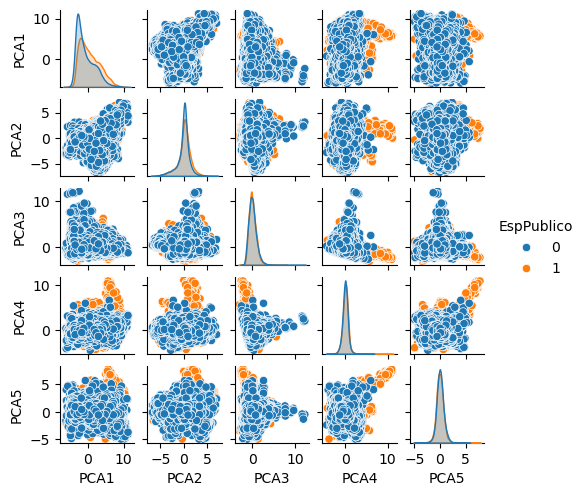

In [47]:
sns.pairplot(variables_gdf[['PCA1','PCA2','PCA3','PCA4','PCA5','EspPublico']], hue='EspPublico', size=1)

## Model construction

### Clasificadores para temperatura, humedad, población, vegetación...

In [48]:
xxx = variables_gdf[["PCA1", "PCA2", "PCA3", "PCA4","PCA5"]]
yyy = variables_gdf['EspPublico']

In [49]:
yyy.unique()

array([1, 0])

### Logistic Regression

In [50]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.3, random_state = 42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  

#Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

#Escalar los datos:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

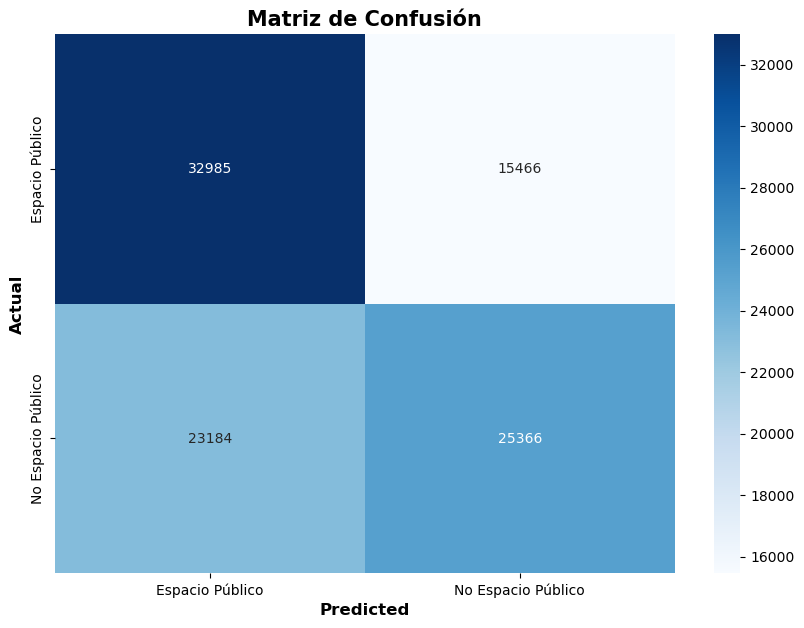

In [51]:
clf = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [52]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6015504994793868


In [53]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.68      0.63     48451
           1       0.62      0.52      0.57     48550

    accuracy                           0.60     97001
   macro avg       0.60      0.60      0.60     97001
weighted avg       0.60      0.60      0.60     97001



In [74]:
'''from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
import numpy as np

log_reg = LogisticRegression(max_iter=1000)

# Definir el grid de hiperparámetros a ajustar
param_dist = {
    'C': np.logspace(-2, 2, 10),  # Distribución logarítmica de C
    'penalty': ['l2'],  # Usar solo penalización l2
    'solver': ['liblinear']
}

#Usar RandomizedSearchCV:
random_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, 
                                   n_iter=10, cv=5, scoring='f1', verbose=1, n_jobs=-1)

random_search.fit(x_train_scale, y_train_clean)

#Usar el mejor modelo encontrado:
best_model = random_search.best_estimator_

print("Mejores hiperparámetros encontrados:", random_search.best_params_)'''


'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.linear_model import LogisticRegression\nimport numpy as np\n\nlog_reg = LogisticRegression(max_iter=1000)\n\n# Definir el grid de hiperparámetros a ajustar\nparam_dist = {\n    \'C\': np.logspace(-2, 2, 10),  # Distribución logarítmica de C\n    \'penalty\': [\'l2\'],  # Usar solo penalización l2\n    \'solver\': [\'liblinear\']\n}\n\n#Usar RandomizedSearchCV:\nrandom_search = RandomizedSearchCV(estimator=log_reg, param_distributions=param_dist, \n                                   n_iter=10, cv=5, scoring=\'f1\', verbose=1, n_jobs=-1)\n\nrandom_search.fit(x_train_scale, y_train_clean)\n\n#Usar el mejor modelo encontrado:\nbest_model = random_search.best_estimator_\n\nprint("Mejores hiperparámetros encontrados:", random_search.best_params_)'

### Naive Bayes

In [54]:
nb3 = GaussianNB()
nb3.fit(x_train_scale, y_train_clean)

GaussianNB()

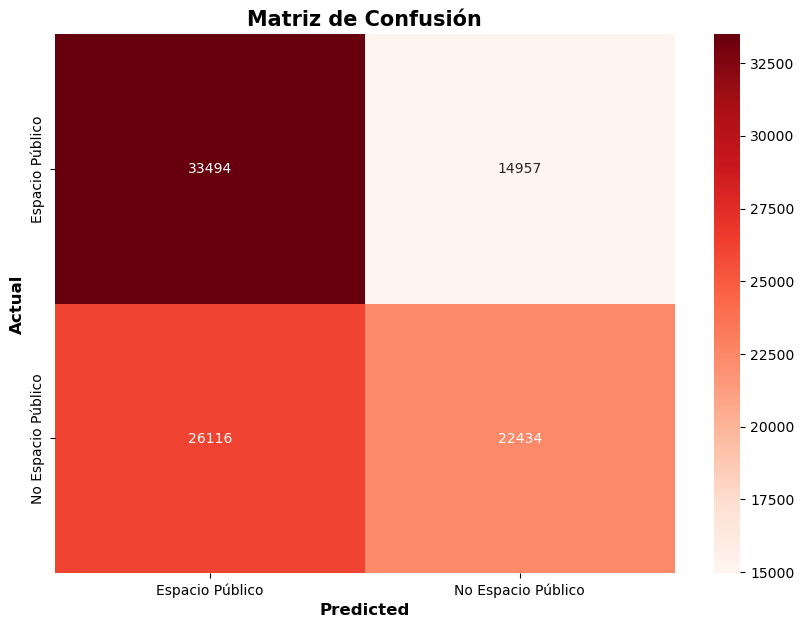

In [55]:
y_prend = nb3.predict(x_test_clean)
cm2 = confusion_matrix(y_test_clean, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [56]:
accuracy = accuracy_score(y_test_clean, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5765713755528293


In [57]:
print(classification_report(y_test_clean, y_prend))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62     48451
           1       0.60      0.46      0.52     48550

    accuracy                           0.58     97001
   macro avg       0.58      0.58      0.57     97001
weighted avg       0.58      0.58      0.57     97001



### Random Forest Classifier

In [58]:
rf3 = RandomForestClassifier(n_estimators = 100, random_state = 123)  
rf3.fit(x_train_scale, y_train_clean)

# Realizar predicciones en el conjunto de prueba
y_predd = rf3.predict(x_test_clean)

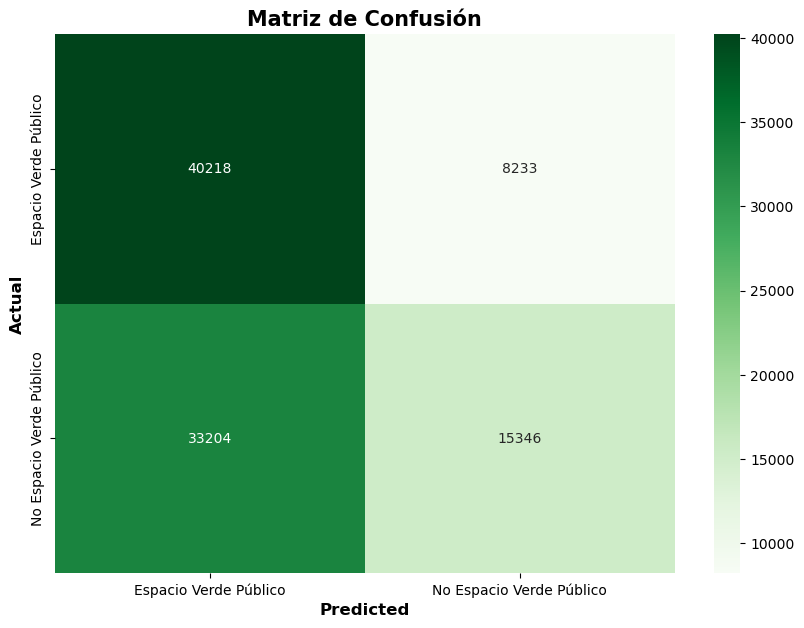

In [59]:
cm2 = confusion_matrix(y_test_clean, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [60]:
accuracy = accuracy_score(y_test_clean, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.572818836919207


In [61]:
print(classification_report(y_test_clean, y_predd))

              precision    recall  f1-score   support

           0       0.55      0.83      0.66     48451
           1       0.65      0.32      0.43     48550

    accuracy                           0.57     97001
   macro avg       0.60      0.57      0.54     97001
weighted avg       0.60      0.57      0.54     97001



### Ada Boost Clasifier

In [62]:
model2 = AdaBoostClassifier(n_estimators = 100)
model2.fit(x_train_scale, y_train_clean)

AdaBoostClassifier(n_estimators=100)

In [63]:
predictions2 = model2.predict(x_test_clean)
predictions2

array([0, 1, 0, ..., 0, 0, 0])

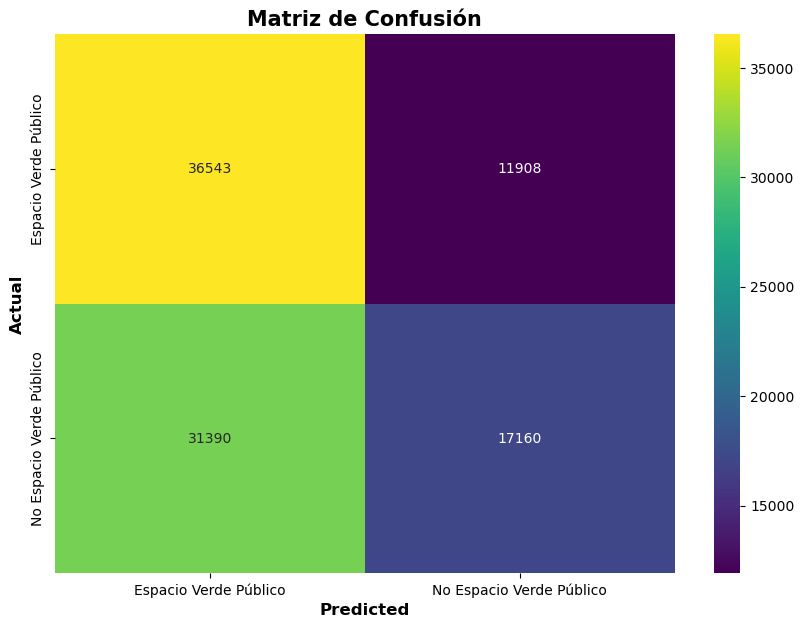

In [64]:
cm2 = confusion_matrix(y_test_clean, predictions2)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="viridis", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [65]:
print(classification_report(y_test_clean, predictions2))

              precision    recall  f1-score   support

           0       0.54      0.75      0.63     48451
           1       0.59      0.35      0.44     48550

    accuracy                           0.55     97001
   macro avg       0.56      0.55      0.54     97001
weighted avg       0.56      0.55      0.53     97001



### XGB Classifier

In [66]:
model22 = xgb.XGBClassifier()
model22.fit(x_train_scale, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
predictions22 = model22.predict(x_test_clean)
predictions22

array([0, 1, 0, ..., 0, 1, 0])

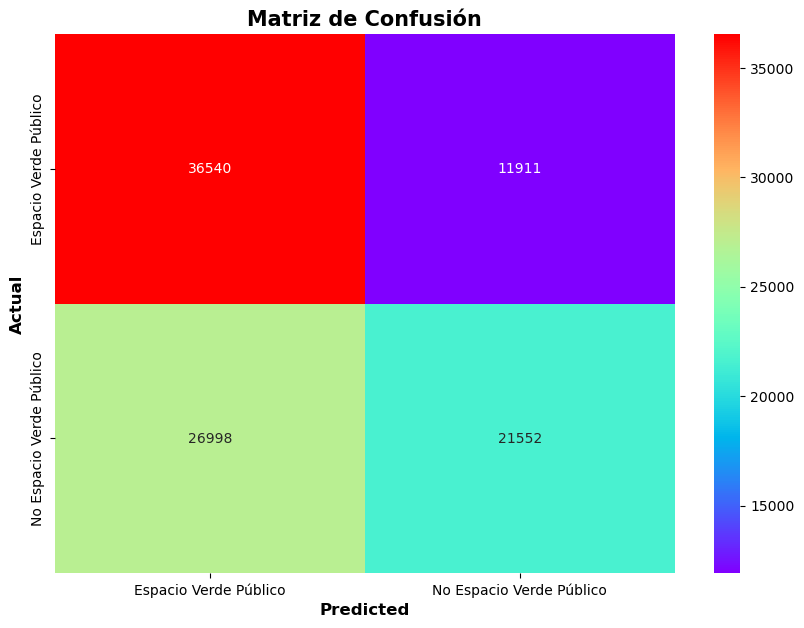

In [68]:
cm2 = confusion_matrix(y_test_clean, predictions22)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="rainbow", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [69]:
print(classification_report(y_test_clean, predictions22))

              precision    recall  f1-score   support

           0       0.58      0.75      0.65     48451
           1       0.64      0.44      0.53     48550

    accuracy                           0.60     97001
   macro avg       0.61      0.60      0.59     97001
weighted avg       0.61      0.60      0.59     97001



In [70]:
accuracy = accuracy_score(y_test_clean, predictions22)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5988804239131555


### Decision Tree Classfier

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
model32 = DecisionTreeClassifier()
model32.fit(x_train_scale, y_train_clean)

DecisionTreeClassifier()

In [73]:
predictions32 = model32.predict(x_test_clean)
predictions32

array([0, 1, 0, ..., 0, 0, 1])

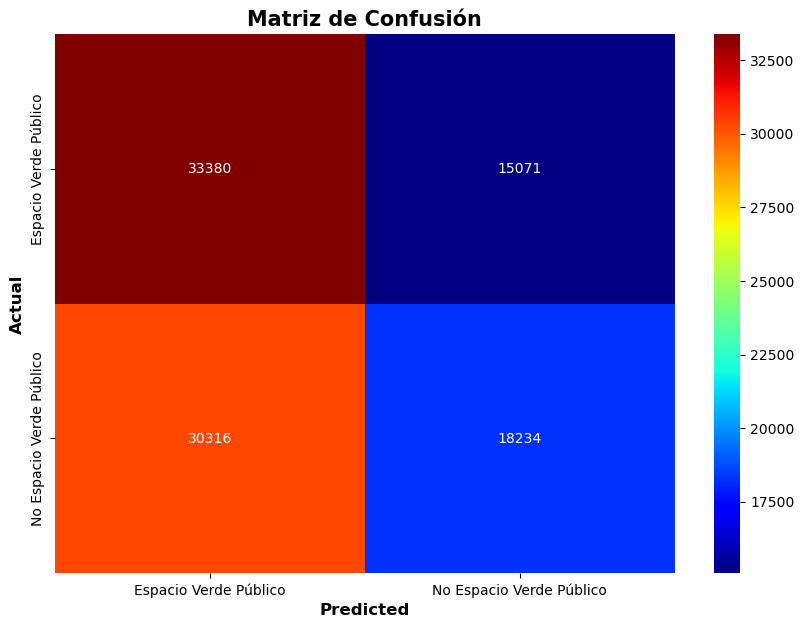

In [74]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="jet", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [75]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.52      0.69      0.60     48451
           1       0.55      0.38      0.45     48550

    accuracy                           0.53     97001
   macro avg       0.54      0.53      0.52     97001
weighted avg       0.54      0.53      0.52     97001



In [76]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5320976072411625


In [77]:
from sklearn.linear_model import SGDClassifier

In [78]:
modell32 = SGDClassifier()
modell32.fit(x_train_scale, y_train_clean)

SGDClassifier()

In [79]:
predictions32 = modell32.predict(x_test_clean)
predictions32

array([1, 1, 0, ..., 0, 1, 0])

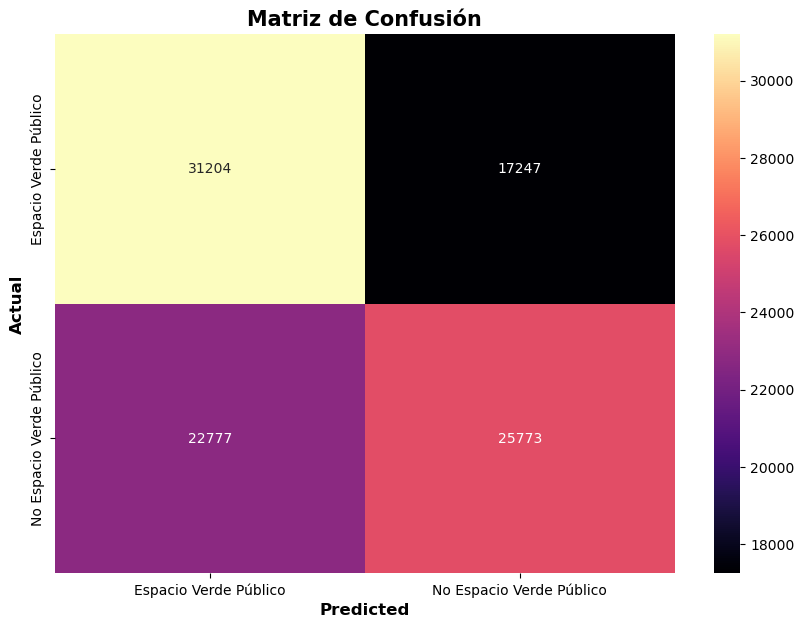

In [80]:
cm2 = confusion_matrix(y_test_clean, predictions32)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm2, annot = True, fmt = "g", cmap="magma", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [81]:
print(classification_report(y_test_clean, predictions32))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61     48451
           1       0.60      0.53      0.56     48550

    accuracy                           0.59     97001
   macro avg       0.59      0.59      0.59     97001
weighted avg       0.59      0.59      0.59     97001



In [82]:
accuracy = accuracy_score(y_test_clean, predictions32)
print(f'Accuracy: {accuracy}')

Accuracy: 0.5873856970546696


### Visualización del comportamiento de las variables en crudo

In [83]:
#xxx = variables_gdf[["pobtot", 'ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', 'temp_diff_mean']]
#yyy = variables_gdf['EspPublico']

In [ ]:
#sns.pairplot(variables_gdf, hue='EspPublico', size=1)

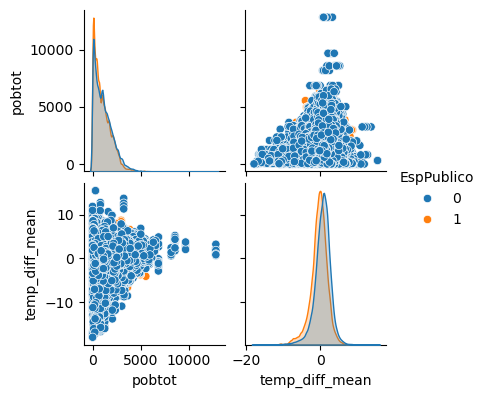

In [84]:
raw_variables1 = variables_gdf[["pobtot", "temp_diff_mean", "EspPublico"]]
sns.pairplot(raw_variables1, hue='EspPublico', size=2)

In [ ]:
#raw_variables2 = variables_gdf[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', "EspPublico"]]
#sns.pairplot(raw_variables2, hue='EspPublico', size=2)

### Clasificador sin Guadalajara

In [85]:
train_with_CDMX = variables_gdf[variables_gdf["city"] == "CDMX"]
train_with_CDMX.head(5)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
6,8b4995b81104fff,CDMX,"POLYGON ((-99.16277 19.46651, -99.16259 19.466...",11,0103000020E61000000100000007000000E91349CE6ACA...,CDMX,11,0103000020E61000000100000007000000E91349CE6ACA...,CDMX,11,...,0.003228,0.020786,1.729628,1,2136.0,-1.651586,1.109499,0.828441,0.036047,0.759040
9,8b499586a874fff,CDMX,"POLYGON ((-99.21307 19.28862, -99.21290 19.288...",11,0103000020E610000001000000070000009ADA52FDA2CD...,CDMX,11,0103000020E610000001000000070000009ADA52FDA2CD...,CDMX,11,...,0.048401,0.044135,-1.967104,1,781.0,2.464149,2.079394,-0.188437,-0.544113,-0.508675
12,8b49958c1849fff,CDMX,"POLYGON ((-99.03129 19.36746, -99.03111 19.367...",11,0103000020E61000000100000007000000C766F7A200C2...,CDMX,11,0103000020E61000000100000007000000C766F7A200C2...,CDMX,11,...,-0.035739,0.034940,2.419656,1,3796.0,-2.757683,0.594306,2.618704,0.071410,0.126456
20,8b499584db9cfff,CDMX,"POLYGON ((-99.22961 19.33170, -99.22943 19.331...",11,0103000020E61000000100000007000000767F6FE1B1CE...,CDMX,11,0103000020E61000000100000007000000767F6FE1B1CE...,CDMX,11,...,0.010763,0.016890,-2.928704,1,120.0,0.569295,1.465517,-1.357721,0.142762,-0.872191
21,8b499585c25cfff,CDMX,"POLYGON ((-99.14545 19.33478, -99.14528 19.335...",11,0103000020E6100000010000000700000009EAFE1D4FC9...,CDMX,11,0103000020E6100000010000000700000009EAFE1D4FC9...,CDMX,11,...,0.047442,0.049513,-3.246356,1,1446.0,0.865373,2.164493,-0.037904,0.916308,-0.366700


In [91]:
xxx = train_with_CDMX[["PCA1", "PCA2", "PCA3", "PCA4","PCA5"]]
yyy = train_with_CDMX['EspPublico']

In [92]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.2, random_state = 42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  

#Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

#Escalar los datos:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

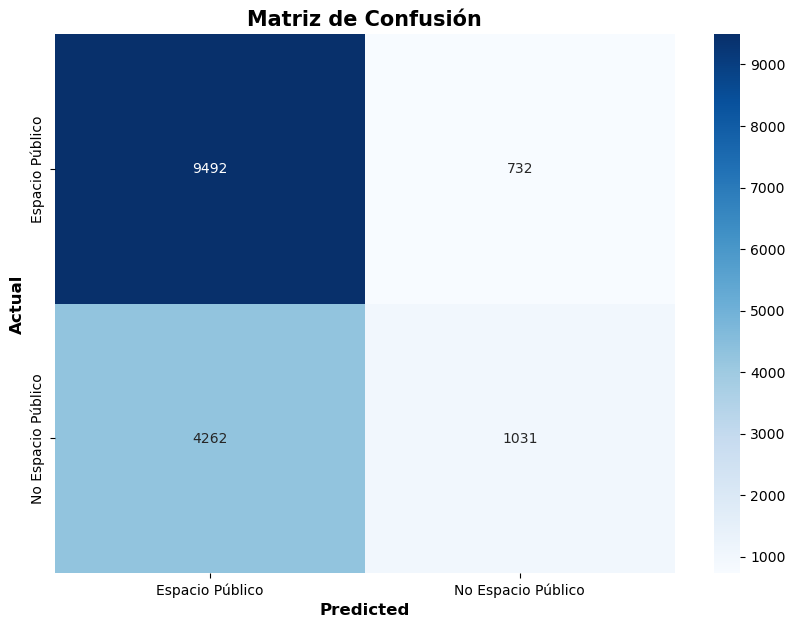

In [93]:
clf = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [94]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6781594380357028


In [95]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79     10224
           1       0.58      0.19      0.29      5293

    accuracy                           0.68     15517
   macro avg       0.64      0.56      0.54     15517
weighted avg       0.65      0.68      0.62     15517



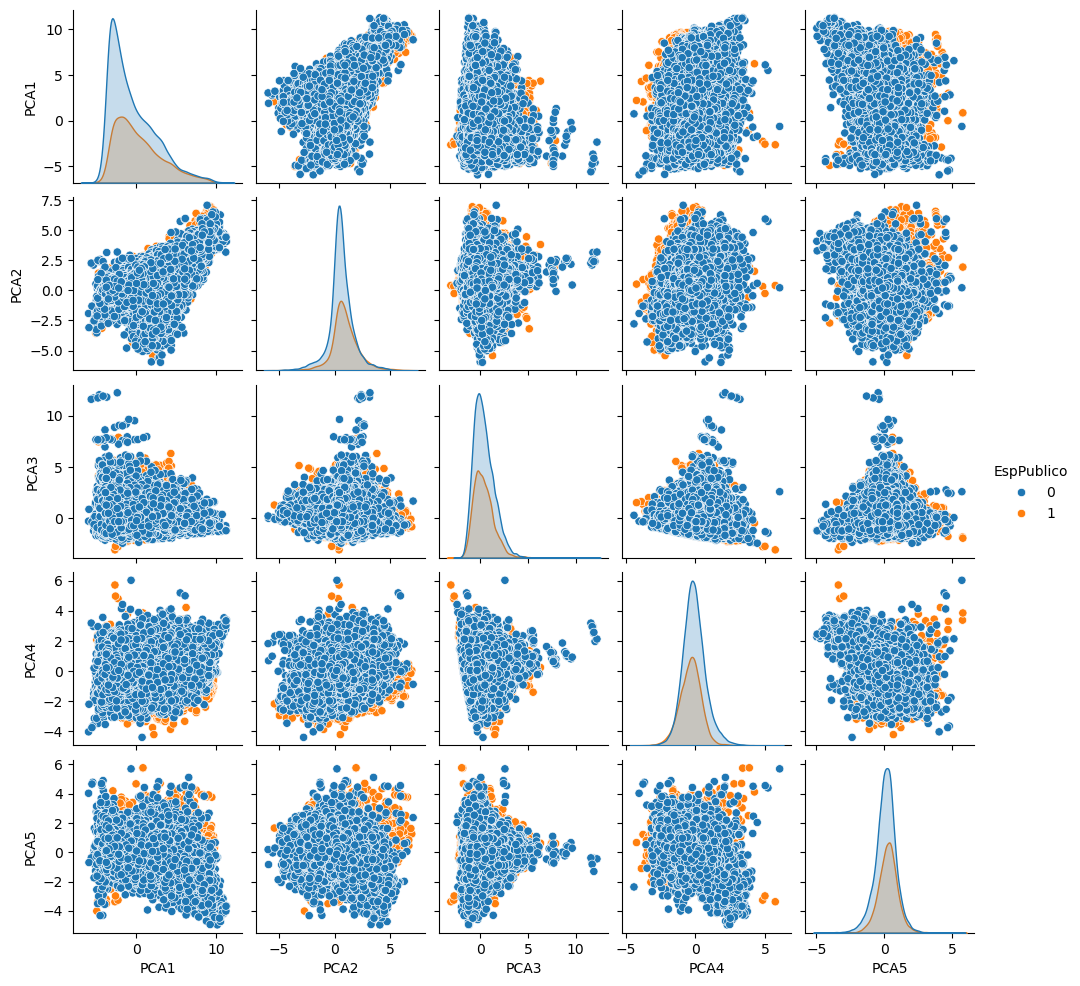

In [105]:
test_CDMX = train_with_CDMX[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "EspPublico"]]
sns.pairplot(test_CDMX, hue='EspPublico', size=2)

### Clasificador sin CDMX

In [97]:
train_with_GDL = variables_gdf[variables_gdf["city"] == "Guadalajara"]
train_with_GDL.head(5)

,hex_id,city,geometry,temp_res,ndmi_geometry,ndmi_city,ndmi_res,ndvi_geometry,ndvi_city,ndvi_res,...,ndmi_median,ndmi_diff,temp_diff_mean,EspPublico,pobtot,PCA1,PCA2,PCA3,PCA4,PCA5
0,8b49ab583548fff,Guadalajara,"POLYGON ((-103.46501 20.64157, -103.46484 20.6...",11,0103000020E61000000100000007000000906FB8C8C2DD...,Guadalajara,11,0103000020E61000000100000007000000906FB8C8C2DD...,Guadalajara,11,...,-0.055511,0.046621,-0.933639,1,2657.0,-2.159160,0.164256,1.255968,0.581917,-1.166528
1,8b498c964104fff,Guadalajara,"POLYGON ((-103.34104 20.60244, -103.34087 20.6...",11,0103000020E61000000100000007000000B14534A2D3D5...,Guadalajara,11,0103000020E61000000100000007000000B14534A2D3D5...,Guadalajara,11,...,-0.037047,0.170562,0.380686,1,1094.0,1.130969,-1.531278,0.548777,-0.024770,0.099711
2,8b498c961a02fff,Guadalajara,"POLYGON ((-103.36826 20.64319, -103.36809 20.6...",11,0103000020E6100000010000000700000037C2059791D7...,Guadalajara,11,0103000020E6100000010000000700000037C2059791D7...,Guadalajara,11,...,-0.032172,0.032824,3.547266,1,646.0,-3.542899,-0.192562,-0.870372,-0.382423,1.084109
3,8b49ab582106fff,Guadalajara,"POLYGON ((-103.44956 20.62362, -103.44938 20.6...",11,0103000020E61000000100000007000000121C8B87C5DC...,Guadalajara,11,0103000020E61000000100000007000000121C8B87C5DC...,Guadalajara,11,...,0.091794,0.040901,-0.203218,1,1704.0,2.893235,2.901834,0.927240,-0.681925,0.655042
4,8b498c90bb51fff,Guadalajara,"POLYGON ((-103.21328 20.66492, -103.21311 20.6...",11,0103000020E610000001000000070000008D65376DA6CD...,Guadalajara,11,0103000020E610000001000000070000008D65376DA6CD...,Guadalajara,11,...,-0.007156,0.068020,1.771559,1,1241.0,-1.736257,0.552380,-0.086836,-0.149983,0.694305


In [99]:
xxx = train_with_GDL[["PCA1", "PCA2", "PCA3", "PCA4","PCA5"]]
yyy = train_with_GDL['EspPublico']

In [100]:
x_train, x_test, y_train, y_test = train_test_split(xxx, yyy, test_size=0.2, random_state = 42)

# Reemplazar valores infinitos por NaN
x_train.replace([np.inf, -np.inf], np.nan, inplace=True)
x_test.replace([np.inf, -np.inf], np.nan, inplace=True)

#Combinar x y y para eliminar filas con NaN de forma coherente
train_data = x_train.copy()
train_data['target'] = y_train  

#Eliminar filas con NaN en el conjunto de entrenamiento
train_data.dropna(inplace=True)

x_train_clean = train_data.drop(columns=['target'])
y_train_clean = train_data['target']

test_data = x_test.copy()
test_data['target'] = y_test
test_data.dropna(inplace=True)

x_test_clean = test_data.drop(columns=['target'])
y_test_clean = test_data['target']

#Escalar los datos:
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train_clean)
x_test_scale = scaler.transform(x_test_clean)

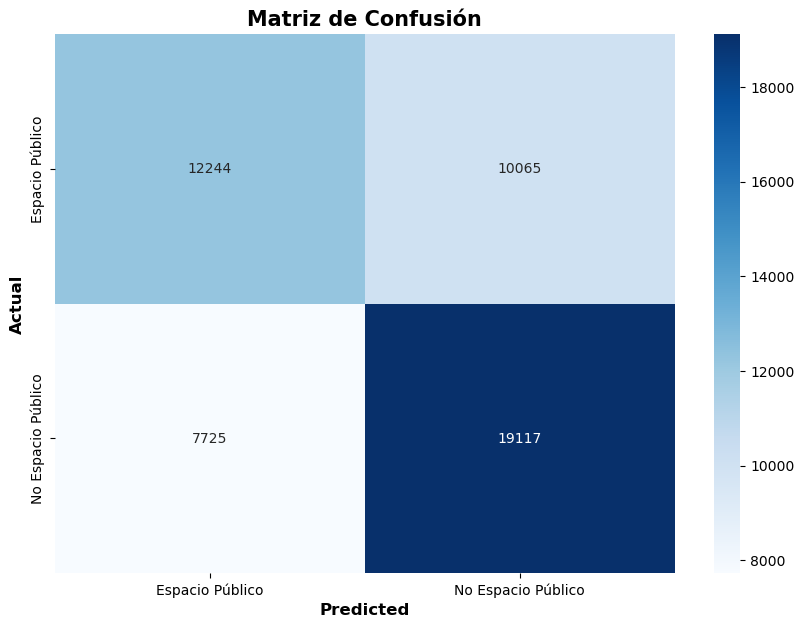

In [101]:
clf = LogisticRegression(max_iter=10000, C=1, penalty='l2', solver='sag', warm_start=True)
clf.fit(x_train_scale, y_train_clean)

y_pred = clf.predict(x_test_scale)

#Generar matriz de confusión:
cm2 = confusion_matrix(y_test_clean, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cm2, annot=True, fmt="g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [102]:
accuracy = accuracy_score(y_test_clean, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6380541596305264


In [103]:
print(classification_report(y_test_clean, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.55      0.58     22309
           1       0.66      0.71      0.68     26842

    accuracy                           0.64     49151
   macro avg       0.63      0.63      0.63     49151
weighted avg       0.64      0.64      0.64     49151



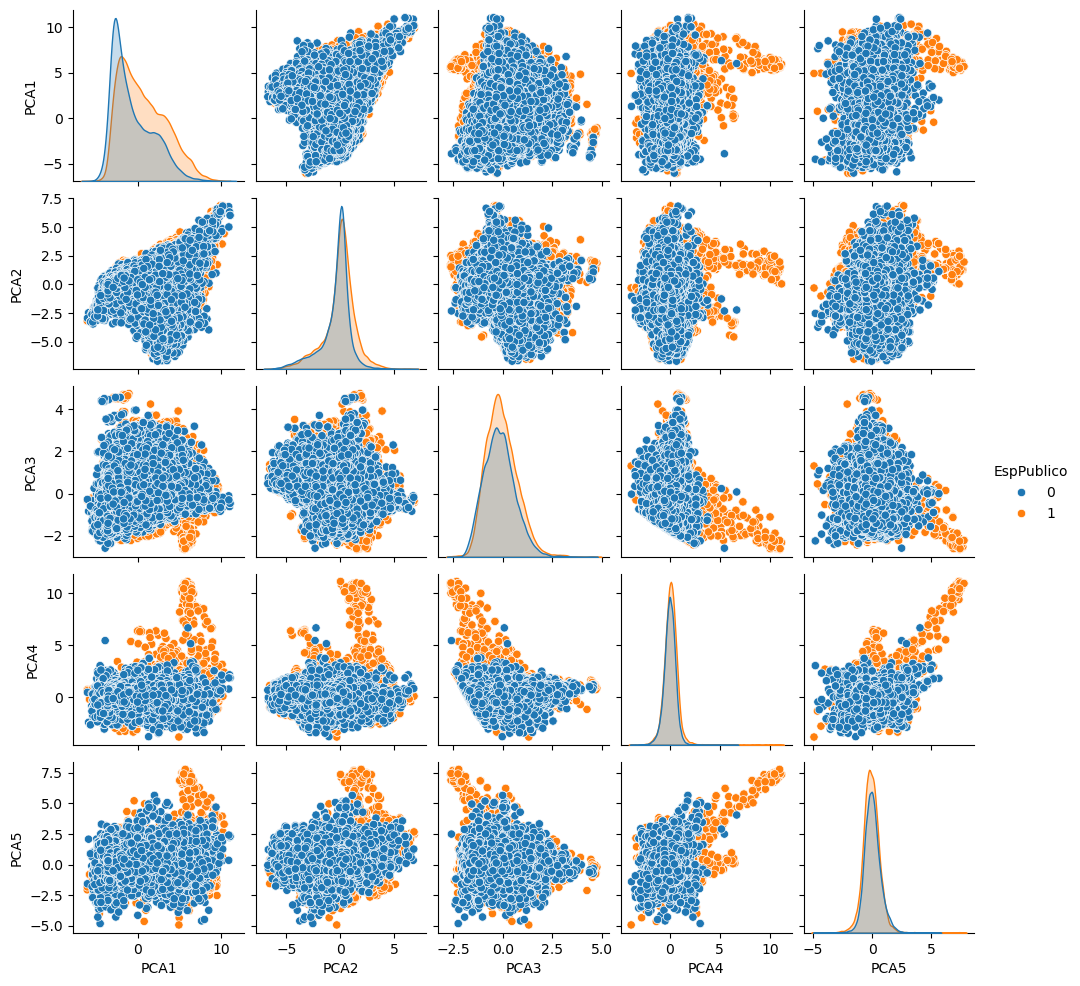

In [106]:
test_GDL = train_with_GDL[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "EspPublico"]]
sns.pairplot(test_GDL, hue='EspPublico', size=2)

### k-NN con ambas ciudades

In [123]:
from sklearn.preprocessing import StandardScaler

XXX = variables_gdf[["PCA1", "PCA2", "PCA3", "PCA4", "PCA5"]]
YYY = variables_gdf['EspPublico']

# Escalar las variables
scaler = StandardScaler()
XXX_scaled = scaler.fit_transform(XXX)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(XXX_scaled, YYY, test_size=0.2, random_state=42)

In [160]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2, metric='minkowski', weights='distance')

# Entrenar el modelo
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [161]:
y_pred = knn.predict(X_test)

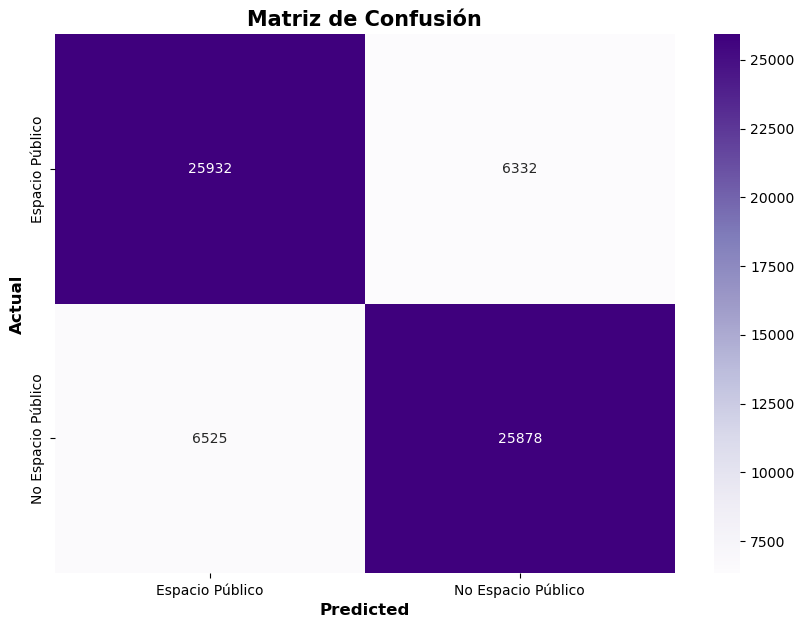

In [162]:
#Generar matriz de confusión:
cmk = confusion_matrix(y_test, y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']

plt.figure(figsize=(10, 7))
sns.heatmap(cmk, annot=True, fmt="g", cmap="Purples", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Matriz de Confusión', fontsize=15, fontweight='bold')
plt.show()

In [163]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8011814372090865

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     32264
           1       0.80      0.80      0.80     32403

    accuracy                           0.80     64667
   macro avg       0.80      0.80      0.80     64667
weighted avg       0.80      0.80      0.80     64667



In [168]:
corr = variables_gdf[["pobtot", 'ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff', 'temp_diff_mean', "EspPublico"]]


target_correlation = corr.corr()["EspPublico"].sort_values(ascending=False)

print(target_correlation)

EspPublico        1.000000
ndvi_median       0.222442
ndvi_mean         0.218743
ndvi_min          0.204802
ndmi_mean         0.201289
ndvi_max          0.194082
ndmi_median       0.184905
ndvi_std          0.153039
ndvi_diff         0.134424
ndmi_diff         0.094902
pobtot           -0.062542
ndvi_tend        -0.163922
temp_diff_mean   -0.206163
Name: EspPublico, dtype: float64
